<a href="https://colab.research.google.com/github/WooranJo/data-science-endeavors/blob/main/dacon/income-prediction/ensemble-modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random
import math

def seed_everything(seed: int = 1024):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
seed_everything()

import warnings
warnings.filterwarnings("ignore")

pd.set_option('float_format', '{:.4f}'.format)

# Data Loading

In [2]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')
sample_submission = pd.read_csv('./sample_submission.csv')

# train_data = pd.concat([train_data, train_data], ignore_index=True)
print(f"train shape: {train_data.shape}")
print(f"test shape: {test_data.shape}")

train shape: (20000, 23)
test shape: (10000, 22)


# Feature Engineering

In [3]:
white_collars = ['Admin Support (include Clerical)', 'Professional', 'Management', 'Technicians & Support']
blue_collars = ['Craft & Repair', 'Machine Operators & Inspectors', 'Handlers/Cleaners', 'Transportation', 'Farming & Forestry & Fishing', 'Protective Services', 'Armed Forces']
pink_collars = ['Services', 'Sales', 'Private Household Services', ]

collar_mapper = {
    'White Collar': white_collars,
    'Blue Collar': blue_collars,
    'Pink Collar': pink_collars
}

def gen_occupation(row):
    return f"{row['Industry_Status']}_{row['Occupation_Status']}"

def gen_family_status(row):
  return f"{row['Household_Status']}_{row['Household_Summary']}"

def gen_origin(row):
    return f"{row['Race']} -{row['Hispanic_Origin']}"

def gen_individual_status(row):
    return f"{row['Martial_Status']}_{row['Tax_Status']}"

def gen_citizenship_tax(row):
  return f"{row['Citizenship']}_{row['Tax_Status']}"

def gen_employment(row):
  return f"{row['Occupation_Status']}_{row['Employment_Status']}"

collars = {}

for key, values in collar_mapper.items():
    for value in values:
        collars[value] = key

def preprocess_df(data):
    df = data.copy()
    df = df.fillna("Household")

    # df['Profit'] = df['Gains'] - df['Losses'] + df['Dividends']
    # # df['CollarColor'] = df['Occupation_Status'].replace(collars)
    # df['Martial_Status'] = df['Martial_Status'].replace({
        # 'Married (Spouse Absent)': 'Widowed',
        # 'Divorced': 'Separated'
    # })

    # df['AgeCat'] = pd.cut(df['Age'], bins=[0, 14, 18, 30, 40, 50, 70, 90],labels=["Child_Teenage","Youth","Adult_30s","Adult_40s","Adult_50s","Adult_60s", "Old"], include_lowest=True).astype(object)
    df['Occupation'] = df.apply(gen_occupation, axis=1)
    # df['WorkingWeekPerYear'] = df['Working_Week (Yearly)'] / 52

    df['Hispanic_Origin'] = df['Hispanic_Origin'].replace({
        "NA": "All other"
    })


    df['Origin'] = df.apply(gen_origin, axis=1)
    df['IndividualStatus'] = df.apply(gen_individual_status, axis=1)
    df['AgeWorking'] = df['Age'] * (df['Working_Week (Yearly)']+1)
    df['ProfitRatio'] = (df['Gains']+df['Dividends']) / (df['Losses']+1)
    df['Citizenship_Tax'] = df.apply(gen_citizenship_tax, axis=1)
    df['Employment'] = df.apply(gen_employment, axis=1)
    df['AgeLosses'] = df['Age'] * (df['Losses']+1)
    df['WorkingLosses'] = (df['Losses']+1) * (df['Working_Week (Yearly)'] + 1)
    df['EmploymentType'] = df['Employment_Status'] + "in " + df['Industry_Status']
    df['CitizenshipStatus'] = df['Birth_Country'] + df['Citizenship']


    drop_cols = ['ID', 'Losses', 'Gains', 'Race', 'Hispanic_Origin', 'Tax_Status', 'Citizenship', 'Birth_Country (Father)', 'Birth_Country (Mother)', 'Birth_Country', 'Martial_Status']

    df.drop(drop_cols, axis=1, inplace=True)
    #  'Birth_Country (Father)', 'Birth_Country (Mother)', , 'Losses', 'Gains', 'Birth_Country (Mother)', 'Birth_Country (Father)', 'Race', 'Hispanic_Origin', 'Tax_Status', 'Citizenship', 'Profit', 'Martial_Status'
    return df

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      20000 non-null  object
 1   Age                     20000 non-null  int64 
 2   Gender                  20000 non-null  object
 3   Education_Status        20000 non-null  object
 4   Employment_Status       20000 non-null  object
 5   Working_Week (Yearly)   20000 non-null  int64 
 6   Industry_Status         20000 non-null  object
 7   Occupation_Status       20000 non-null  object
 8   Race                    20000 non-null  object
 9   Hispanic_Origin         20000 non-null  object
 10  Martial_Status          20000 non-null  object
 11  Household_Status        20000 non-null  object
 12  Household_Summary       20000 non-null  object
 13  Citizenship             20000 non-null  object
 14  Birth_Country           20000 non-null  object
 15  Bi

# Data Preprocessing

In [5]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, PolynomialFeatures, MaxAbsScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
!pip install category_encoders
from category_encoders import OneHotEncoder, CatBoostEncoder, MEstimateEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer, make_column_selector

target = 'Income'

train = preprocess_df(train_data)
test = preprocess_df(test_data)

train.dropna(subset=target, inplace=True)
# train.drop_duplicates(inplace=True)

# train.reset_index(inplace=True, drop=True)

print(test.isnull().sum())
print(f"Got {len(train.columns)} features: {train.columns}")

preprocessor = ColumnTransformer(transformers=[
    ("mse", MEstimateEncoder(handle_unknown="value"), make_column_selector(dtype_include=object)),
    ("scale", MaxAbsScaler(), make_column_selector(dtype_include=np.number)),
],
    verbose_feature_names_out=True
)

X_raw = train.drop(target, axis=1)
y = train[target]

preprocessor.fit(X_raw, y)
X = preprocessor.transform(X_raw)

X_test = preprocessor.transform(test)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2)

Age                      0
Gender                   0
Education_Status         0
Employment_Status        0
Working_Week (Yearly)    0
Industry_Status          0
Occupation_Status        0
Household_Status         0
Household_Summary        0
Dividends                0
Income_Status            0
Occupation               0
Origin                   0
IndividualStatus         0
AgeWorking               0
ProfitRatio              0
Citizenship_Tax          0
Employment               0
AgeLosses                0
WorkingLosses            0
EmploymentType           0
CitizenshipStatus        0
dtype: int64
Got 23 features: Index(['Age', 'Gender', 'Education_Status', 'Employment_Status',
       'Working_Week (Yearly)', 'Industry_Status', 'Occupation_Status',
       'Household_Status', 'Household_Summary', 'Dividends', 'Income_Status',
       'Income', 'Occupation', 'Origin', 'IndividualStatus', 'AgeWorking',
       'ProfitRatio', 'Citizenship_Tax', 'Employment', 'AgeLosses',
       'WorkingLos

In [6]:
print(train.shape)
print(train_data.shape)
print(X.shape)
print(train.info())

(20000, 23)
(20000, 23)
(20000, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    20000 non-null  int64  
 1   Gender                 20000 non-null  object 
 2   Education_Status       20000 non-null  object 
 3   Employment_Status      20000 non-null  object 
 4   Working_Week (Yearly)  20000 non-null  int64  
 5   Industry_Status        20000 non-null  object 
 6   Occupation_Status      20000 non-null  object 
 7   Household_Status       20000 non-null  object 
 8   Household_Summary      20000 non-null  object 
 9   Dividends              20000 non-null  int64  
 10  Income_Status          20000 non-null  object 
 11  Income                 20000 non-null  int64  
 12  Occupation             20000 non-null  object 
 13  Origin                 20000 non-null  object 
 14  IndividualStatus  

In [7]:
# 전처리 후 데이터의 null값 확인
print(np.where(np.isnan(X))[0])
print(np.where(np.isnan(X_test))[0])

[]
[]


# Modeling with Optuna

In [8]:
!pip install optuna
import optuna

from xgboost import XGBRegressor

!pip install catboost
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, RepeatedKFold, GridSearchCV

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
rkf = RepeatedKFold(n_repeats=3, n_splits=10)

In [9]:
def objective_lgbm(trial):
    params = {
        "objective": "regression_l1",
        "data_sample_strategy": trial.suggest_categorical("data_sample_strategy", ["bagging", "goss"]),
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "rf"]), # "dart" - It takes too long
        "learning_rate" : trial.suggest_float("learning_rate", 1e-4, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 300, 1000),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-4, 1.0),
        'lambda_l2': trial.suggest_float("lambda_l2", 1e-4, 1.0),
        "n_jobs": -1,
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1),
        "subsample": trial.suggest_float("subsample", 1e-4, 1.0),
        # "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        # "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1),
#         "feature_pre_filter": False,

        'feature_fraction': trial.suggest_float("feature_fraction", 1e-4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 1e-4, 1.0)
        # 'min_child_samples': trial.suggest_int("min_child_samples", 10, 50),
#         "early_stopping_round": 100,
#         "extra_trees": True,
        # "device_type": "cuda",
        # "min_child_sample": 1
    }

    if params["data_sample_strategy"] == "bagging":
        params["bagging_fraction"] = trial.suggest_float("bagging_fraction", 1e-4, 1.0)
        params["bagging_freq"] = trial.suggest_int("bagging_freq", 1, 10)

    try:

      reg = LGBMRegressor(**params)
      reg.fit(X_train, y_train)

      predictions = reg.predict(X_val)

      rmse = math.sqrt(mean_squared_error(y_val, predictions))

      return rmse
    except:
        return 1000


study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=100, timeout=600)
trial_lgbm = study_lgbm.best_trial
best_params_lgbm = trial_lgbm.params

final_params_lgbm = best_params_lgbm
final_params_lgbm.update({
    "importance_type": "gain",
#     "device_type": "cuda",
    "objective": "regression",
    "metric": "rmse",
    # "early_stopping_round": 100,
    "n_jobs": -1,
    "verbosity": -1,
})

print(f"Best parameters of LGBMClassifier model: {final_params_lgbm}")

scores_lgbm = []
for i, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    lgbm_reg = LGBMRegressor(**final_params_lgbm)
    lgbm_reg.fit(X_train_fold, y_train_fold,
                 )

    preds = lgbm_reg.predict(X_val_fold)
    rmse = math.sqrt(mean_squared_error(y_val_fold, preds))


    scores_lgbm.append(rmse)
    print(f"{i+1} Fold RMSE: {rmse}")
print(f"Average Mean Squared Error of LGBMRegressor: {np.mean(scores_lgbm)}")

[I 2024-04-30 05:33:35,901] A new study created in memory with name: no-name-a19bc11a-8b30-4f4a-860f-366fa5341d7b
[I 2024-04-30 05:33:40,988] Trial 0 finished with value: 559.9452504537521 and parameters: {'data_sample_strategy': 'bagging', 'boosting_type': 'rf', 'learning_rate': 0.5711145062248124, 'n_estimators': 823, 'lambda_l1': 0.6410629540862103, 'lambda_l2': 0.6198434605911004, 'colsample_bytree': 0.7937219197988505, 'subsample': 0.5167822756822793, 'feature_fraction': 0.5680071793223365, 'bagging_fraction': 0.3111194742697701, 'bagging_freq': 1}. Best is trial 0 with value: 559.9452504537521.
[I 2024-04-30 05:33:51,061] Trial 1 finished with value: 560.2614174559917 and parameters: {'data_sample_strategy': 'bagging', 'boosting_type': 'rf', 'learning_rate': 0.10796540871982029, 'n_estimators': 563, 'lambda_l1': 0.5392900297874598, 'lambda_l2': 0.7583924162468503, 'colsample_bytree': 0.959135309228343, 'subsample': 0.247897586542697, 'feature_fraction': 0.3512881917889341, 'baggi

Best parameters of LGBMClassifier model: {'data_sample_strategy': 'goss', 'boosting_type': 'gbdt', 'learning_rate': 0.010907550227937164, 'n_estimators': 843, 'lambda_l1': 0.9960031568288812, 'lambda_l2': 0.09236337802988596, 'colsample_bytree': 0.9411510344599207, 'subsample': 0.24234061644103388, 'feature_fraction': 0.4104295056532912, 'bagging_fraction': 0.35911335216888235, 'importance_type': 'gain', 'objective': 'regression', 'metric': 'rmse', 'n_jobs': -1, 'verbosity': -1}
1 Fold RMSE: 550.6933206774215
2 Fold RMSE: 573.0735331857862
3 Fold RMSE: 584.1902019026437
4 Fold RMSE: 581.7523841755741
5 Fold RMSE: 646.4101912223712
6 Fold RMSE: 589.3827266473437
7 Fold RMSE: 601.6476625278316
8 Fold RMSE: 532.1797066281526
9 Fold RMSE: 604.9641136338063
10 Fold RMSE: 583.0067485185855
Average Mean Squared Error of LGBMRegressor: 584.7300589119516


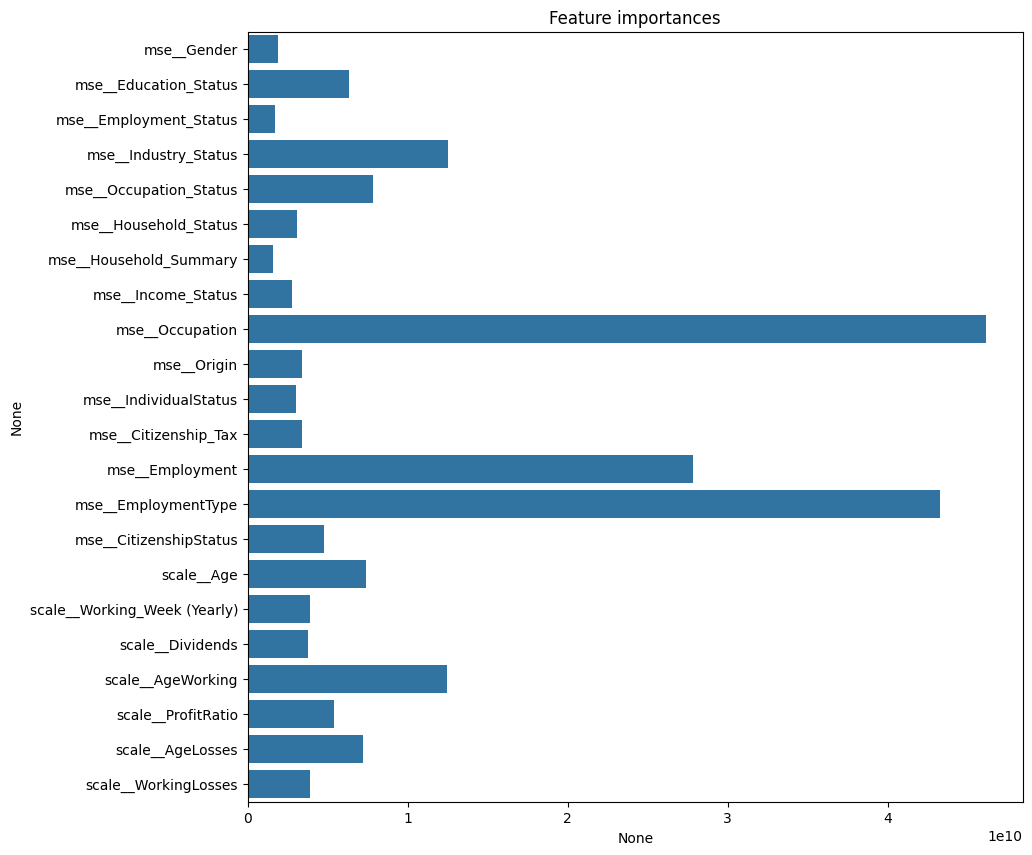

In [10]:
importances_lgbm = pd.Series(lgbm_reg.feature_importances_, index=preprocessor.get_feature_names_out())
fig, ax = plt.subplots(figsize=(10, 10))

sns.barplot(x=importances_lgbm, y=importances_lgbm.index)
ax.set_title("Feature importances")

plt.show()

In [11]:
def objective_cb(trial):
    param = {
        "iterations": trial.suggest_int('iterations', 100, 1000),
        "objective": "RMSE",
        "depth": trial.suggest_int("depth", 3, 16),
        "boosting_type": "Plain",
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
#         "used_ram_limit": "8gb",
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
        # "grow_policy": trial.suggest_categorical("grow_policy", ["Lossguide", "Depthwise"]),# "Depthwise",
        "grow_policy": "Lossguide",
        "early_stopping_rounds": 100,
        "loss_function": "RMSE",
        "eval_metric": "RMSE", # PRAUC:type=OneVsAll
        # "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 1e-5, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 10),
        "random_state": 42,
        "rsm": 0.1,
        # "leaf_estimation_method": trial.suggest_categorical("leaf_estimation_method", ["Newton", "Gradient"]),
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    else:
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cat_reg = CatBoostRegressor(**param)
    cat_reg.fit(X_train, y_train,
              #  eval_set=[(X_val, y_val)],
               verbose=False
               )
    predictions = cat_reg.predict(X_val)

    rmse = math.sqrt(mean_squared_error(y_val, predictions))

    return rmse

study_cb = optuna.create_study(direction='minimize')
study_cb.optimize(objective_cb, n_trials=100, timeout=600)
trial_cb = study_cb.best_trial
best_params_cb = trial_cb.params

other_params_cb = {
    "objective": "RMSE",
    "boosting_type": "Plain",
    "loss_function":"RMSE",
    "eval_metric":"RMSE",
    "random_state": 42,
    "rsm": 0.1,
}

final_params_cb = best_params_cb
final_params_cb.update(other_params_cb)

print(f"Best parameters of CatBoost models: {final_params_cb}")

[I 2024-04-30 05:40:15,889] A new study created in memory with name: no-name-ca5c075c-4717-41c0-8305-03ec7952527d
[I 2024-04-30 05:40:23,236] Trial 0 finished with value: 570.8240991325272 and parameters: {'iterations': 556, 'depth': 8, 'bootstrap_type': 'Bayesian', 'learning_rate': 0.003399065815383141, 'l2_leaf_reg': 7.702121809043436, 'bagging_temperature': 9.65321611502641}. Best is trial 0 with value: 570.8240991325272.
[I 2024-04-30 05:40:26,346] Trial 1 finished with value: 555.3886677105 and parameters: {'iterations': 171, 'depth': 4, 'bootstrap_type': 'Bernoulli', 'learning_rate': 0.04318886931920092, 'l2_leaf_reg': 3.2359960882560768, 'subsample': 0.7161432216179391}. Best is trial 1 with value: 555.3886677105.
[I 2024-04-30 05:40:28,806] Trial 2 finished with value: 586.0006823301796 and parameters: {'iterations': 276, 'depth': 4, 'bootstrap_type': 'MVS', 'learning_rate': 0.718303013967858, 'l2_leaf_reg': 9.69076276605498, 'subsample': 0.287208911822538}. Best is trial 1 wit

Best parameters of CatBoost models: {'iterations': 940, 'depth': 5, 'bootstrap_type': 'Bayesian', 'learning_rate': 0.04838125412220687, 'l2_leaf_reg': 9.335723858410875, 'bagging_temperature': 9.973382507518147, 'objective': 'RMSE', 'boosting_type': 'Plain', 'loss_function': 'RMSE', 'eval_metric': 'RMSE', 'random_state': 42, 'rsm': 0.1}


In [12]:
scores_cat = []
for i, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    cat_reg = CatBoostRegressor(**final_params_cb)
    cat_reg.fit(X_train_fold, y_train_fold, verbose=False)

    preds = cat_reg.predict(X_val_fold)
    rmse = math.sqrt(mean_squared_error(y_val_fold, preds))


    scores_cat.append(rmse)
    print(f"{i+1} Fold RMSE: {rmse}")

print(f"Average Rooted Mean Squared Error of CatRegressor: {np.mean(scores_cat)}")

1 Fold RMSE: 550.2198965747239
2 Fold RMSE: 572.1971587003003
3 Fold RMSE: 587.140520600839
4 Fold RMSE: 581.0431718901739
5 Fold RMSE: 648.9989707310699
6 Fold RMSE: 590.7824093089841
7 Fold RMSE: 595.995289738835
8 Fold RMSE: 529.0223992781939
9 Fold RMSE: 604.3008400602757
10 Fold RMSE: 580.6710731204074
Average Rooted Mean Squared Error of CatRegressor: 584.0371730003803


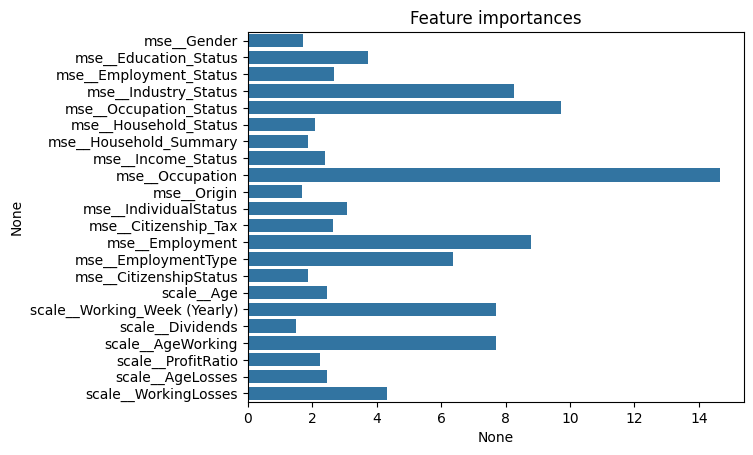

In [13]:
importances_cat = pd.Series(cat_reg.feature_importances_, index=preprocessor.get_feature_names_out())

fig, ax = plt.subplots()

sns.barplot(x=importances_cat, y=importances_cat.index)
ax.set_title("Feature importances")

plt.show()

In [14]:
def find_best(objective, n_trials=100, timeout=600):
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials, timeout=timeout)

    trial = study.best_trial
    best_params = trial.params

    return best_params

def objective_xgb(trial):
    param = {
        # "device": "cuda",
        "verbosity": 0,
        "objective": "reg:squarederror",
        "eval_metric": mean_squared_error,
        # "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        # "early_stopping_rounds": 100,
        "tree_method": trial.suggest_categorical("tree_method", ["approx", "hist"]),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-8, 0.1),
        "subsample": trial.suggest_float("subsample", 1e-4, 1.0),
        # "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1),
        "random_state": 42
    }
    #
#     if param["booster"] == "gbtree" or param["booster"] == "dart":
#         param["max_depth"] = trial.suggest_int("max_depth", 1, 20)
#         param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
#         param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
# #         param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
#     if param["booster"] == "dart":
#         param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
#         param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
#         param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
#         param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    xgb_reg = XGBRegressor(**param)
    xgb_reg.fit(X_train,
                y_train,
                verbose=False
                )
    preds = xgb_reg.predict(X_val)

    score = math.sqrt(mean_squared_error(y_val, preds))

    return score

best_params_xgb = find_best(objective=objective_xgb)

other_params_xgb = {
    "verbosity": 0,
    "objective": "reg:squarederror",
    "eval_metric": mean_squared_error,
    "random_state": 42

}

final_params_xgb = best_params_xgb
final_params_xgb.update(other_params_xgb)

print(f"Best parameter of XGBoost models: {final_params_xgb}")

scores_xgb = []
for i, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    xgb_reg = XGBRegressor(**final_params_xgb)

    xgb_reg.fit(X_train_fold, y_train_fold,
               verbose=False)
    preds = xgb_reg.predict(X_val_fold)

    score = math.sqrt(mean_squared_error(y_val_fold, preds))
    scores_xgb.append(score)

    print(f"{i+1} Fold RMSE: {score}")

print(f"Average Rooted Mean Squared Error of XGBRegressor: {np.mean(scores_xgb)}")

[I 2024-04-30 05:48:21,306] A new study created in memory with name: no-name-dbe8e2e7-ddca-43c5-93c2-d2a90660bf21
[I 2024-04-30 05:48:23,302] Trial 0 finished with value: 563.0407448984876 and parameters: {'lambda': 3.7624936903587356e-05, 'alpha': 0.0029155855461095205, 'gamma': 2.205700873034106e-08, 'n_estimators': 615, 'tree_method': 'hist', 'grow_policy': 'depthwise', 'learning_rate': 0.010968241399222978, 'subsample': 0.4414112840658843}. Best is trial 0 with value: 563.0407448984876.
[I 2024-04-30 05:48:26,653] Trial 1 finished with value: 650.3448582611252 and parameters: {'lambda': 4.867525193034039e-07, 'alpha': 0.0055242098858086595, 'gamma': 5.256898089847697e-07, 'n_estimators': 640, 'tree_method': 'approx', 'grow_policy': 'depthwise', 'learning_rate': 0.09537506232642502, 'subsample': 0.2648393941252011}. Best is trial 0 with value: 563.0407448984876.
[I 2024-04-30 05:48:28,917] Trial 2 finished with value: 597.3311305484087 and parameters: {'lambda': 1.0588865308641498e-

Best parameter of XGBoost models: {'lambda': 0.33204399057967166, 'alpha': 2.4422945231990127e-08, 'gamma': 0.014558863124507842, 'n_estimators': 145, 'tree_method': 'hist', 'grow_policy': 'lossguide', 'learning_rate': 0.01988193541182783, 'subsample': 0.9763503660453582, 'verbosity': 0, 'objective': 'reg:squarederror', 'eval_metric': <function mean_squared_error at 0x7e313ea4ba30>, 'random_state': 42}
1 Fold RMSE: 554.111930895386
2 Fold RMSE: 572.0473132954519
3 Fold RMSE: 600.508386944257
4 Fold RMSE: 579.7626444225289
5 Fold RMSE: 648.626515379849
6 Fold RMSE: 590.7674154591474
7 Fold RMSE: 596.8547982824743
8 Fold RMSE: 532.6856422549721
9 Fold RMSE: 614.9523587130184
10 Fold RMSE: 587.5307058654519
Average Rooted Mean Squared Error of XGBRegressor: 587.7847711512536


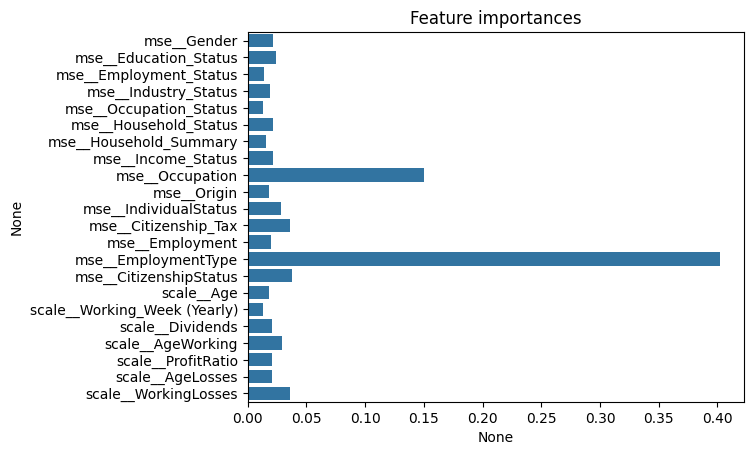

In [15]:
importances_xgb = pd.Series(xgb_reg.feature_importances_, index=preprocessor.get_feature_names_out())
fig, ax = plt.subplots()

sns.barplot(x=importances_xgb, y=importances_xgb.index)
ax.set_title("Feature importances")
plt.show()

In [16]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

def objective_rf(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 16),
        "min_weight_fraction_leaf": trial.suggest_float("min_weight_fraction_leaf", 0.0, 0.5),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "warm_start": True,
        "n_jobs": -1,
        "verbose": 0,
        "random_state": 42
    }


    rf_reg = RandomForestRegressor(**param)
    rf_reg.fit(X_train,
               y_train,
               )
    preds = rf_reg.predict(X_val)

    score = math.sqrt(mean_squared_error(y_val, preds))

    return score

best_params_rf = find_best(objective=objective_rf)

other_params_rf = {
    "warm_start": True,
    "n_jobs": -1,
    "verbose": 0,
    "random_state": 42
}

final_params_rf = best_params_rf
final_params_rf.update(other_params_rf)

print(f"Best parameter of RandomForest model: {final_params_rf}")

scores_rf = []
for i, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    rf_reg = RandomForestRegressor(**final_params_rf)

    rf_reg.fit(X_train_fold, y_train_fold)
    preds = rf_reg.predict(X_val_fold)

    score = math.sqrt(mean_squared_error(y_val_fold, preds))
    scores_rf.append(score)

    print(f"{i+1} Fold RMSE: {score}")

print(f"Average Rooted Mean Squared Error of RandomForestRegressor: {np.mean(scores_rf)}")

[I 2024-04-30 05:51:22,846] A new study created in memory with name: no-name-3e452c60-1f1e-4fa5-8241-12af90ba4136
[I 2024-04-30 05:51:23,577] Trial 0 finished with value: 604.0402356193348 and parameters: {'n_estimators': 237, 'min_samples_split': 8, 'min_weight_fraction_leaf': 0.48571821120051595, 'max_depth': 15, 'max_features': 'log2'}. Best is trial 0 with value: 604.0402356193348.
[I 2024-04-30 05:51:26,224] Trial 1 finished with value: 594.6699816276144 and parameters: {'n_estimators': 878, 'min_samples_split': 13, 'min_weight_fraction_leaf': 0.417123321216414, 'max_depth': 6, 'max_features': 'sqrt'}. Best is trial 1 with value: 594.6699816276144.
[I 2024-04-30 05:51:41,186] Trial 2 finished with value: 565.0954006232314 and parameters: {'n_estimators': 993, 'min_samples_split': 15, 'min_weight_fraction_leaf': 0.12437752498986443, 'max_depth': 19, 'max_features': None}. Best is trial 2 with value: 565.0954006232314.
[I 2024-04-30 05:51:44,997] Trial 3 finished with value: 568.557

Best parameter of RandomForest model: {'n_estimators': 333, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0023063442420333696, 'max_depth': 17, 'max_features': 'log2', 'warm_start': True, 'n_jobs': -1, 'verbose': 0, 'random_state': 42}
1 Fold RMSE: 549.4662136641977
2 Fold RMSE: 569.426341741668
3 Fold RMSE: 583.9916469462192
4 Fold RMSE: 579.1091314675767
5 Fold RMSE: 650.585134963407
6 Fold RMSE: 591.2621714452456
7 Fold RMSE: 595.3994661634523
8 Fold RMSE: 531.9715880788267
9 Fold RMSE: 602.9103024321142
10 Fold RMSE: 582.1261918621267
Average Rooted Mean Squared Error of RandomForestRegressor: 583.6248188764833


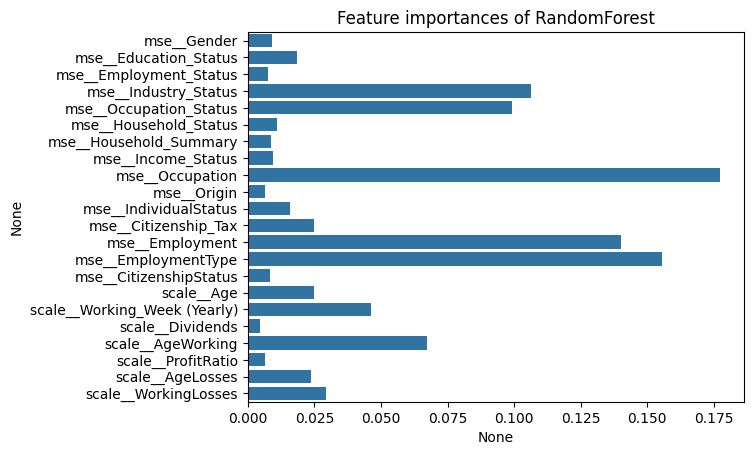

In [17]:
importances_rf = pd.Series(rf_reg.feature_importances_, index=preprocessor.get_feature_names_out())
fig, ax = plt.subplots()

sns.barplot(x=importances_rf, y=importances_rf.index)
ax.set_title("Feature importances of RandomForest")

plt.show()

In [18]:
print(importances_rf.T.sort_values())

scale__Dividends               0.0045
mse__Origin                    0.0063
scale__ProfitRatio             0.0064
mse__Employment_Status         0.0075
mse__CitizenshipStatus         0.0083
mse__Household_Summary         0.0087
mse__Gender                    0.0089
mse__Income_Status             0.0096
mse__Household_Status          0.0110
mse__IndividualStatus          0.0160
mse__Education_Status          0.0186
scale__AgeLosses               0.0238
mse__Citizenship_Tax           0.0247
scale__Age                     0.0247
scale__WorkingLosses           0.0292
scale__Working_Week (Yearly)   0.0463
scale__AgeWorking              0.0671
mse__Occupation_Status         0.0993
mse__Industry_Status           0.1062
mse__Employment                0.1401
mse__EmploymentType            0.1555
mse__Occupation                0.1773
dtype: float64


In [19]:
from sklearn.ensemble import HistGradientBoostingRegressor

def objective_hgb(trial):
    param = {
        "max_iter": trial.suggest_int("max_iter", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1.0),
        "l2_regularization": trial.suggest_float("l2_regularization", 1e-8, 1.0),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "validation_fraction": 0.2,
        "n_iter_no_change": 100,
        "loss": trial.suggest_categorical("loss", ["squared_error", "poisson"]),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 10, 30),
        # "categorical_features": True,
        "random_state": 42
    }


    hgb_reg = HistGradientBoostingRegressor(**param)
    hgb_reg.fit(X_train,
               y_train,
               )
    preds = hgb_reg.predict(X_val)

#     score = f1_score(y_val_fold, preds, average='macro')
    try:
      score = math.sqrt(mean_squared_error(y_val, preds))

      return score
    except:
      return 1000

best_params_hgb = find_best(objective=objective_hgb)

other_params_hgb = {
    "verbose": 0,
    "validation_fraction": 0.2,
    "n_iter_no_change": 100,
    "random_state": 42
}

final_params_hgb = best_params_hgb
final_params_hgb.update(other_params_hgb)

print(f"Best parameter of HistGradientBoosting model: {final_params_hgb}")

scores_hgb = []
for i, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    hgb_reg = HistGradientBoostingRegressor(**final_params_hgb)

    hgb_reg.fit(X_train_fold, y_train_fold)
    preds = hgb_reg.predict(X_val_fold)

    score = math.sqrt(mean_squared_error(y_val_fold, preds))
    scores_hgb.append(score)

    print(f"{i+1} Fold RMSE: {score}")

print(f"Average Rooted Mean Squared Error of HistGradientBoosting: {np.mean(scores_hgb)}")

[I 2024-04-30 05:59:23,970] A new study created in memory with name: no-name-df7226a1-d8c6-47d4-bc09-90ecfe4a9489
[I 2024-04-30 05:59:24,813] Trial 0 finished with value: 643.7261982401491 and parameters: {'max_iter': 695, 'learning_rate': 0.6430079220252422, 'l2_regularization': 0.7556828088745889, 'max_depth': 9, 'loss': 'poisson', 'min_samples_leaf': 29}. Best is trial 0 with value: 643.7261982401491.
[I 2024-04-30 05:59:25,608] Trial 1 finished with value: 663.8319894230812 and parameters: {'max_iter': 912, 'learning_rate': 0.6339256217074328, 'l2_regularization': 0.40887156816591874, 'max_depth': 13, 'loss': 'poisson', 'min_samples_leaf': 13}. Best is trial 0 with value: 643.7261982401491.
[I 2024-04-30 05:59:26,422] Trial 2 finished with value: 866.0779992049038 and parameters: {'max_iter': 454, 'learning_rate': 0.948664348011818, 'l2_regularization': 0.9848688394283879, 'max_depth': 20, 'loss': 'poisson', 'min_samples_leaf': 11}. Best is trial 0 with value: 643.7261982401491.
[I

Best parameter of HistGradientBoosting model: {'max_iter': 199, 'learning_rate': 0.019034206974076623, 'l2_regularization': 0.19040684811654424, 'max_depth': 13, 'loss': 'squared_error', 'min_samples_leaf': 30, 'verbose': 0, 'validation_fraction': 0.2, 'n_iter_no_change': 100, 'random_state': 42}
1 Fold RMSE: 552.0477984870356
2 Fold RMSE: 571.0591869369069
3 Fold RMSE: 585.4606714334991
4 Fold RMSE: 581.3380006493477
5 Fold RMSE: 646.4957344956601
6 Fold RMSE: 590.48534849257
7 Fold RMSE: 598.9628742495964
8 Fold RMSE: 533.5399448633768
9 Fold RMSE: 605.8013361436164
10 Fold RMSE: 582.0600961629401
Average Rooted Mean Squared Error of HistGradientBoosting: 584.7250991914549


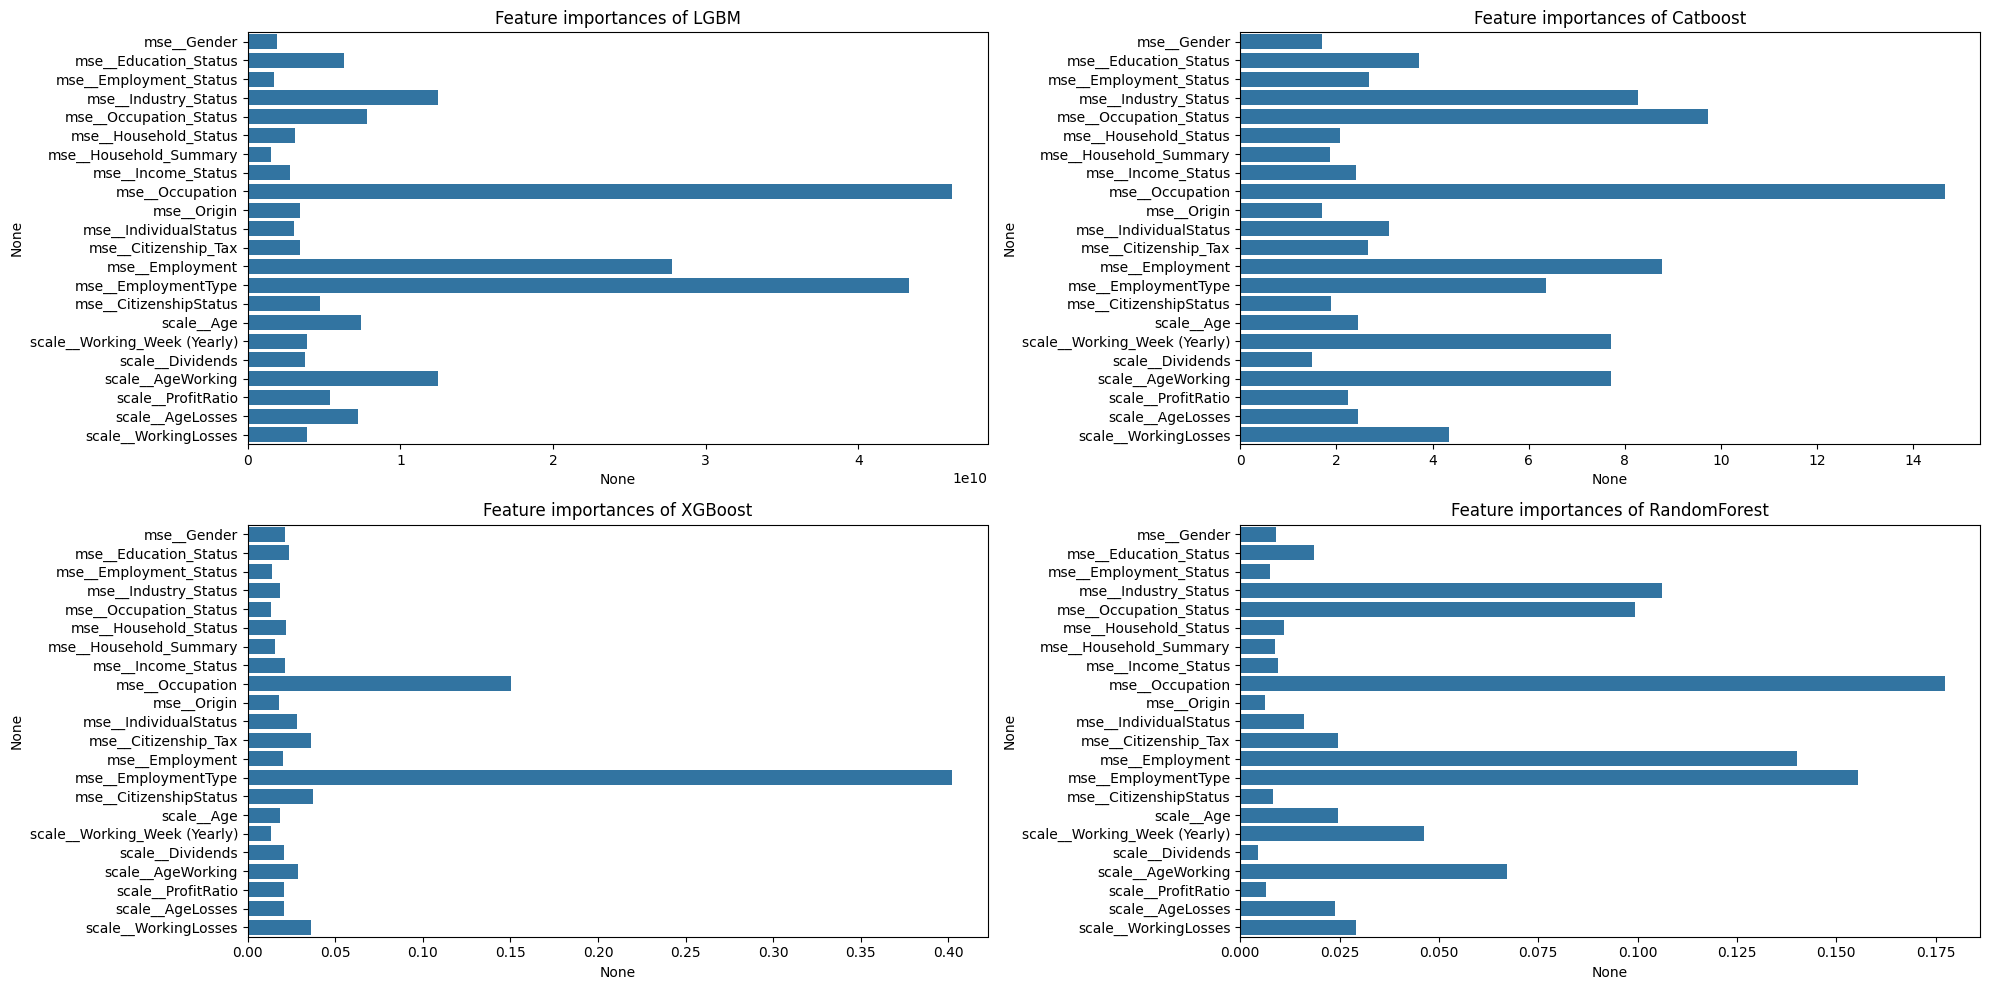

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))


sns.barplot(x=importances_lgbm, y=importances_lgbm.index, ax=axes[0][0])
sns.barplot(x=importances_cat, y=importances_cat.index, ax=axes[0][1])
sns.barplot(x=importances_xgb, y=importances_xgb.index, ax=axes[1][0])
sns.barplot(x=importances_rf, y=importances_rf.index, ax=axes[1][1])
axes[0][0].set_title("Feature importances of LGBM")
axes[0][1].set_title("Feature importances of Catboost")
axes[1][0].set_title("Feature importances of XGBoost")
axes[1][1].set_title("Feature importances of RandomForest")

plt.tight_layout()

In [22]:
# print(f"""
# *** Average Rooted Mean Squared Error ***
# LGBM: {np.mean(scores_lgbm)}
# XGB: {np.mean(scores_xgb)}
# CAT: {np.mean(scores_cat)}
# RF: {np.mean(scores_rf)}
# HGB: {np.mean(scores_hgb)}
# """)
# # IL: {np.mean(scores_ilr)}

# estimators = [
#     ('cat', cat_reg), ('lgbm', lgbm_reg), ('xgb', xgb_reg)
#     # ('xgb', xgb_reg), ('cat', cat_reg), ('lgbm', lgbm_reg), ('ilr', ilr),  ('gb', gb_reg),
# ]

performances = pd.DataFrame([("LGBM", np.mean(scores_lgbm), lgbm_reg), ("XGB", np.mean(scores_xgb), xgb_reg), ("CAT", np.mean(scores_cat), cat_reg), ("HGB", np.mean(scores_hgb), hgb_reg), ("RF", np.mean(scores_rf), rf_reg)])
performances.columns = ["Model_Name", "RMSE_Score", "Model"]
performances.sort_values(by='RMSE_Score', inplace=True)
print(f"""
*** Average Root Mean Squared Error ***
{performances}
""")

estimators = [(model_name, model) for (model_name, score, model) in performances.values][:2]

print(f"Selected estimators: {[name for (name, model) in estimators]}")


*** Average Root Mean Squared Error ***
  Model_Name  RMSE_Score                                              Model
4         RF    583.6248  (DecisionTreeRegressor(max_depth=17, max_featu...
2        CAT    584.0372  <catboost.core.CatBoostRegressor object at 0x7...
3        HGB    584.7251  HistGradientBoostingRegressor(l2_regularizatio...
0       LGBM    584.7301  LGBMRegressor(bagging_fraction=0.3591133521688...
1        XGB    587.7848  XGBRegressor(alpha=2.4422945231990127e-08, bas...

Selected estimators: ['RF', 'CAT']


# Ensemble (Stacking: best 3 models)

In [23]:
from sklearn.ensemble import VotingRegressor, StackingRegressor

scores_ensemble = []

ensemble_model = StackingRegressor(
    estimators=estimators,
    cv=10,
    # n_jobs=4,
    verbose=1
)
ensemble_model.fit(X, y)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
640:	learn: 565.2469647	total: 2.12s	remaining: 991ms
641:	learn: 565.2261950	total: 2.13s	remaining: 987ms
642:	learn: 565.1478793	total: 2.13s	remaining: 984ms
643:	learn: 565.0771691	total: 2.13s	remaining: 980ms
644:	learn: 565.0673399	total: 2.13s	remaining: 976ms
645:	learn: 565.0404137	total: 2.14s	remaining: 973ms
646:	learn: 565.0227224	total: 2.14s	remaining: 970ms
647:	learn: 564.9670263	total: 2.14s	remaining: 966ms
648:	learn: 564.9129538	total: 2.15s	remaining: 963ms
649:	learn: 564.9059542	total: 2.15s	remaining: 959ms
650:	learn: 564.8836600	total: 2.15s	remaining: 956ms
651:	learn: 564.8403478	total: 2.15s	remaining: 952ms
652:	learn: 564.8170722	total: 2.16s	remaining: 949ms
653:	learn: 564.8015172	total: 2.16s	remaining: 945ms
654:	learn: 564.8015172	total: 2.16s	remaining: 941ms
655:	learn: 564.8015172	total: 2.16s	remaining: 937ms
656:	learn: 564.7482790	total: 2.17s	remaining: 933ms
657:	learn: 564.7400302	total: 2.17s	remaining

StackingRegressor(cv=10,
                  estimators=[('RF',
                               RandomForestRegressor(max_depth=17,
                                                     max_features='log2',
                                                     min_samples_split=10,
                                                     min_weight_fraction_leaf=0.0023063442420333696,
                                                     n_estimators=333,
                                                     n_jobs=-1, random_state=42,
                                                     warm_start=True)),
                              ('CAT',
                               <catboost.core.CatBoostRegressor object at 0x7e310d49a740>)],
                  verbose=1)

In [24]:
# print(f"{stacking_model.score(X, y)}")
print(f"""
Score of Ensemble model: {ensemble_model.score(X, y)}
""")
# Average RMSE of Voting model: {np.mean(scores_ensemble)}
# Score of Voting model: 0.3771663188100788
# Average RMSE of Voting model: 582.199743908446
# => 538.55


Score of Ensemble model: 0.36004422285179527



In [25]:
# X_test[np.isnan(X_test)]
np.where(np.isnan(X))[0] # X에 결측치가 있을 경우 predict 불가, 사전 확인

array([], dtype=int64)

### 데이터 분석 결과 기반 후처리

In [26]:
test_data[target] = ensemble_model.predict(X_test)
test_data[test_data['Industry_Status'] == "Not in universe or children"]



def apply_(row):
  if row['Industry_Status'] == "Not in universe or children":
    return 0
  else:
    return row[target]

test_data[target] = test_data.apply(apply_, axis=1)

In [27]:
train.Employment_Status.value_counts()
train[train['Employment_Status'] == 'Not Working']['Income'].value_counts()

Income
0    1221
Name: count, dtype: int64

# Submitting

In [28]:
submission = test_data[['ID', target]]
submission.to_csv(f'./submission.{ensemble_model.score(X, y):.3f}.csv', index=False)

# Single Model

In [ ]:
test_data[target] = lgbm_reg.predict(X_test)
test_data[test_data['Industry_Status'] == "Not in universe or children"]

def apply_(row):
  if row['Industry_Status'] == "Not in universe or children":
    return 0
  else:
    return row[target]

test_data[target] = test_data.apply(apply_, axis=1)

submission = test_data[['ID', target]]
submission.to_csv(f'./submission.{np.mean(scores_lgbm):.3f}.csv', index=False)